# Monte Carlo Predictive coding demo for unsupervised/generative learning 

This notebook demonstrates how to train a Monte Carlo predictive coding (MCPC) model with one input x_0 and one latent state x_1. This network is illustrated below. (a) shows the equivalent generative model and (b) shows the local implementation of PC.

<div style="text-align:center">
    <img src="src/simple_model.png" alt="Image Description" width="600">
</div>


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import predictive_coding as pc

Define utility functions

In [22]:
# This function define the loss function of the input layer of the model. 
# The loss function of the other layers is define in the model definition.
def fe_fn(output, _target):
    return 0.5*(output - _target).pow(2).sum()

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(torch.Tensor(1,out_features), requires_grad=True)

        # Initialize bias
        nn.init.xavier_normal_(self.bias)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same

# function to initialize the activity of latent layers before inference
def sample_x_fn(inputs):
    return torch.randn_like(inputs['mu']) + inputs['mu'].detach().clone()

# function to add noise to the inference dynamics of the PC layers
def random_step(t, _trainer, var=2.):
    """
        var: sets the variance of the noise.
    """
    xs = _trainer.get_model_xs()
    optimizer = _trainer.get_optimizer_x()
    for x in xs:
        x.grad.normal_(0.,np.sqrt(var/optimizer.defaults['lr']))
    optimizer.step()

def mcpc_energy_fn(inputs, lr, noise_var, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var + np.sqrt(2*noise_var/lr)*torch.randn_like(inputs['mu'])*inputs['x']

def pc_energy_fn(inputs, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var

def pc_sample_x_fn(inputs):
    return inputs['mu'].detach().clone()


Define MCPC model

In [23]:
# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 
    
T_mixing = 150                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 1                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD          # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations


# create MCPC model    
mcpc_model = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=pc_sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1., "var": 1.}),
    nn.Linear(hidden_size, output_size, bias=False),
)
mcpc_model.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model[0].bias, 1.)
nn.init.constant_(mcpc_model[2].weight, 7.) 


Parameter containing:
tensor([[7.]], requires_grad=True)

Define trainer that manages the inferences and weight updates of the PC models

In [24]:
inference_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/151 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 1.152e+03 | e: 1.366e+02 | o: 1.289e+03 |:   0%|          | 0/151 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| l: 3.941e+01 | e: 2.811e+01 | o: 6.753e+01 |: 100%|██████████| 151/151 [00:00<00:00, 487.66it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\

<Figure size 640x480 with 0 Axes>

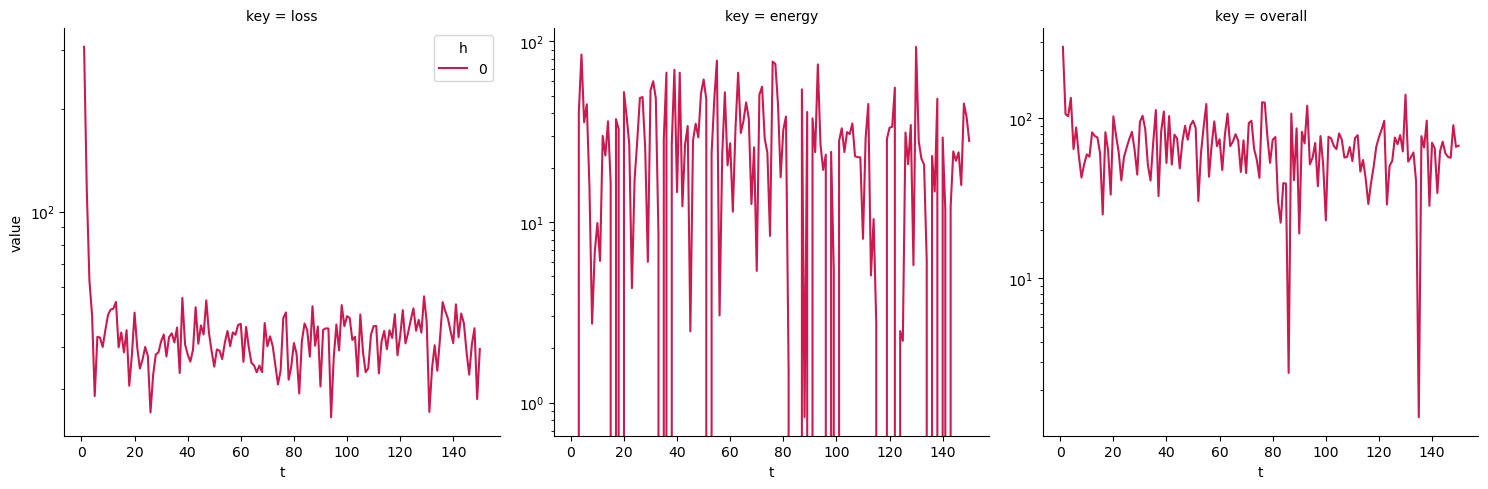

<Figure size 640x480 with 0 Axes>

In [25]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=True, is_return_results_every_t=True) 

### Train the model

Update trainer for learning

In [26]:
training_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [27]:
# data parameters
mu=1.               # data mean
var=5.              # data variance
batch_size = 256    
n = 150              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [28]:
n_epochs = 15   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")

    print(mcpc_model[0].bias)
    print(mcpc_model[2].weight)
        

Epoch: 1, Energy: 330.02: 100%|██████████| 150/150 [00:12<00:00, 12.46it/s] 


Parameter containing:
tensor([[0.4659]], requires_grad=True)
Parameter containing:
tensor([[2.0144]], requires_grad=True)


Epoch: 2, Energy: 570.08: 100%|██████████| 150/150 [00:11<00:00, 12.74it/s] 


Parameter containing:
tensor([[0.4730]], requires_grad=True)
Parameter containing:
tensor([[1.9786]], requires_grad=True)


Epoch: 3, Energy: -65.28: 100%|██████████| 150/150 [00:11<00:00, 12.57it/s] 


Parameter containing:
tensor([[0.4880]], requires_grad=True)
Parameter containing:
tensor([[2.0280]], requires_grad=True)


Epoch: 4, Energy: 349.9: 100%|██████████| 150/150 [00:13<00:00, 10.87it/s]  


Parameter containing:
tensor([[0.4648]], requires_grad=True)
Parameter containing:
tensor([[2.0614]], requires_grad=True)


Epoch: 5, Energy: 101.47: 100%|██████████| 150/150 [00:14<00:00, 10.06it/s] 


Parameter containing:
tensor([[0.5207]], requires_grad=True)
Parameter containing:
tensor([[1.8972]], requires_grad=True)


Epoch: 6, Energy: 173.32: 100%|██████████| 150/150 [00:14<00:00, 10.06it/s] 


Parameter containing:
tensor([[0.4848]], requires_grad=True)
Parameter containing:
tensor([[2.0429]], requires_grad=True)


Epoch: 7, Energy: 575.3: 100%|██████████| 150/150 [00:17<00:00,  8.58it/s]  


Parameter containing:
tensor([[0.5323]], requires_grad=True)
Parameter containing:
tensor([[1.9258]], requires_grad=True)


Epoch: 8, Energy: 151.67: 100%|██████████| 150/150 [00:14<00:00, 10.36it/s] 


Parameter containing:
tensor([[0.4805]], requires_grad=True)
Parameter containing:
tensor([[2.0653]], requires_grad=True)


Epoch: 9, Energy: 210.68: 100%|██████████| 150/150 [00:17<00:00,  8.65it/s] 


Parameter containing:
tensor([[0.4953]], requires_grad=True)
Parameter containing:
tensor([[1.9846]], requires_grad=True)


Epoch: 10, Energy: -43.26: 100%|██████████| 150/150 [00:16<00:00,  8.83it/s] 


Parameter containing:
tensor([[0.4400]], requires_grad=True)
Parameter containing:
tensor([[2.1272]], requires_grad=True)


Epoch: 11, Energy: 380.94: 100%|██████████| 150/150 [00:16<00:00,  9.06it/s] 


Parameter containing:
tensor([[0.4964]], requires_grad=True)
Parameter containing:
tensor([[2.0313]], requires_grad=True)


Epoch: 12, Energy: 211.67: 100%|██████████| 150/150 [00:14<00:00, 10.33it/s] 


Parameter containing:
tensor([[0.4761]], requires_grad=True)
Parameter containing:
tensor([[2.1577]], requires_grad=True)


Epoch: 13, Energy: 124.53: 100%|██████████| 150/150 [00:15<00:00,  9.97it/s] 


Parameter containing:
tensor([[0.5089]], requires_grad=True)
Parameter containing:
tensor([[2.1347]], requires_grad=True)


Epoch: 14, Energy: 102.58: 100%|██████████| 150/150 [00:15<00:00,  9.84it/s] 


Parameter containing:
tensor([[0.4964]], requires_grad=True)
Parameter containing:
tensor([[2.0933]], requires_grad=True)


Epoch: 15, Energy: -87.18: 100%|██████████| 150/150 [00:34<00:00,  4.30it/s] 

Parameter containing:
tensor([[0.5953]], requires_grad=True)
Parameter containing:
tensor([[2.0171]], requires_grad=True)


### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [29]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model[:],
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1., "var": 1.}) #sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1.})
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T = 10000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = {"lr":0.01},
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 4.021e+02 | o: 4.021e+02 |:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: -8.304e+01 | o: -8.304e+01 |: 100%|██████████| 10000/10000 [00:55<00:00, 181.57it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\pre

<Figure size 640x480 with 0 Axes>

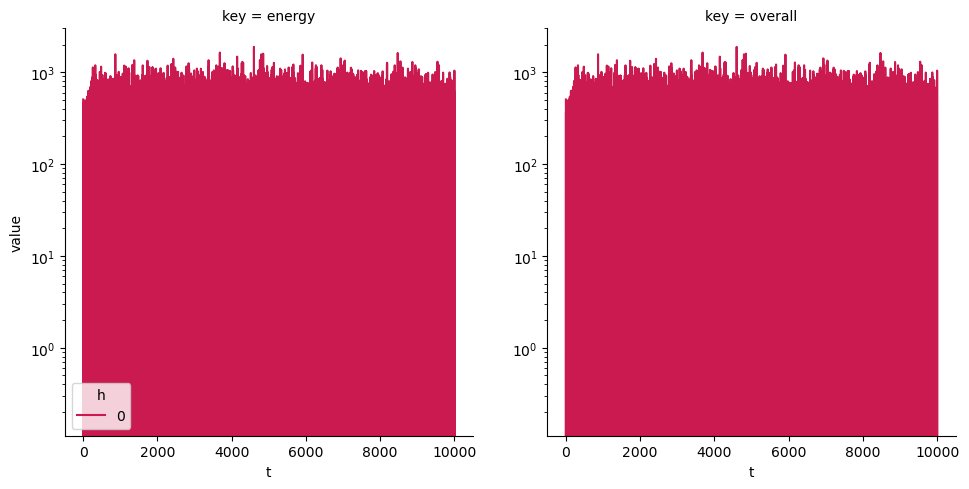

<Figure size 640x480 with 0 Axes>

In [30]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

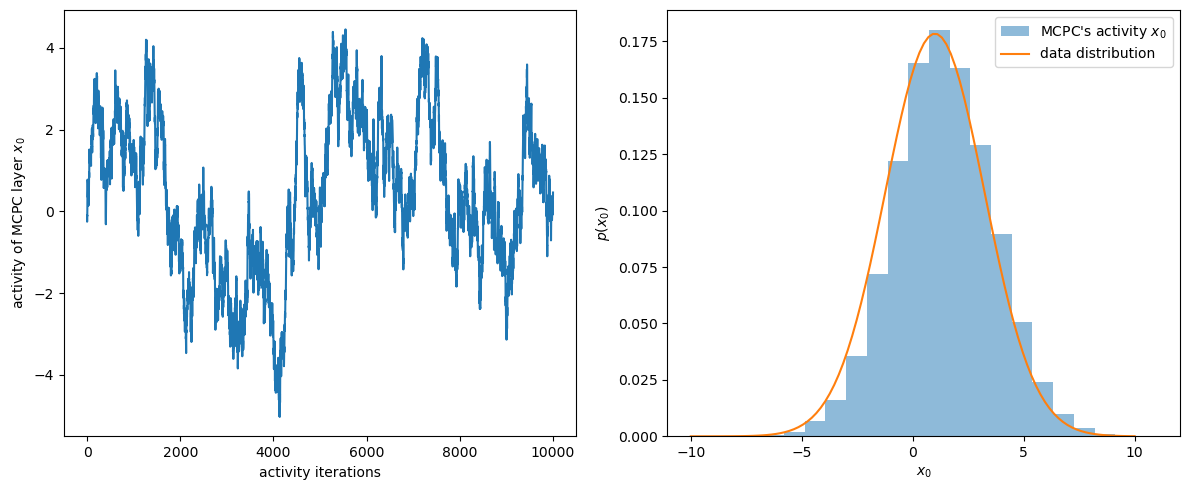

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[4,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=20, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()

In [32]:
print(mcpc_model[0].bias)
print(mcpc_model[2].weight)

Parameter containing:
tensor([[0.5953]], requires_grad=True)
Parameter containing:
tensor([[2.0171]], requires_grad=True)


### Second order Langevin

In [3]:
def mcpc_energy_fn_2nd(inputs, lr, noise_var, momentum):
    return 0.5 *(inputs['mu'] - inputs['x'])**2 + np.sqrt(2*noise_var*(1-momentum)/lr)*torch.randn_like(inputs['mu'])*inputs['x']

In [18]:
# second order langevin dynamics
lr = 0.01
momentum = 0.5

# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 
    
T_mixing = 250                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 1                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD          # optimizer for latent state x
optimizer_x_kwargs = {'lr': lr, "momentum":momentum}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations


# create MCPC model    
mcpc_model_2nd = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn_2nd, energy_fn_kwargs={'lr': lr, 'noise_var': 1., "momentum": momentum}),
    nn.Linear(hidden_size, output_size, bias=False),
)
mcpc_model_2nd.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model_2nd[0].bias, 1.)
nn.init.constant_(mcpc_model_2nd[2].weight, 7.) 


Define trainer that manages the inferences and weight updates of the PC models

In [19]:
inference_trainer = pc.PCTrainer(mcpc_model_2nd, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/251 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 1.581e+05 | e: 3.924e+03 | o: 1.620e+05 |:   0%|          | 0/251 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| l: 3.872e+01 | e: 2.933e+01 | o: 6.804e+01 |: 100%|██████████| 251/251 [00:00<00:00, 568.18it/s] 
c:\Users\olivi\OneDrive - Nexus365\Projects

<Figure size 640x480 with 0 Axes>

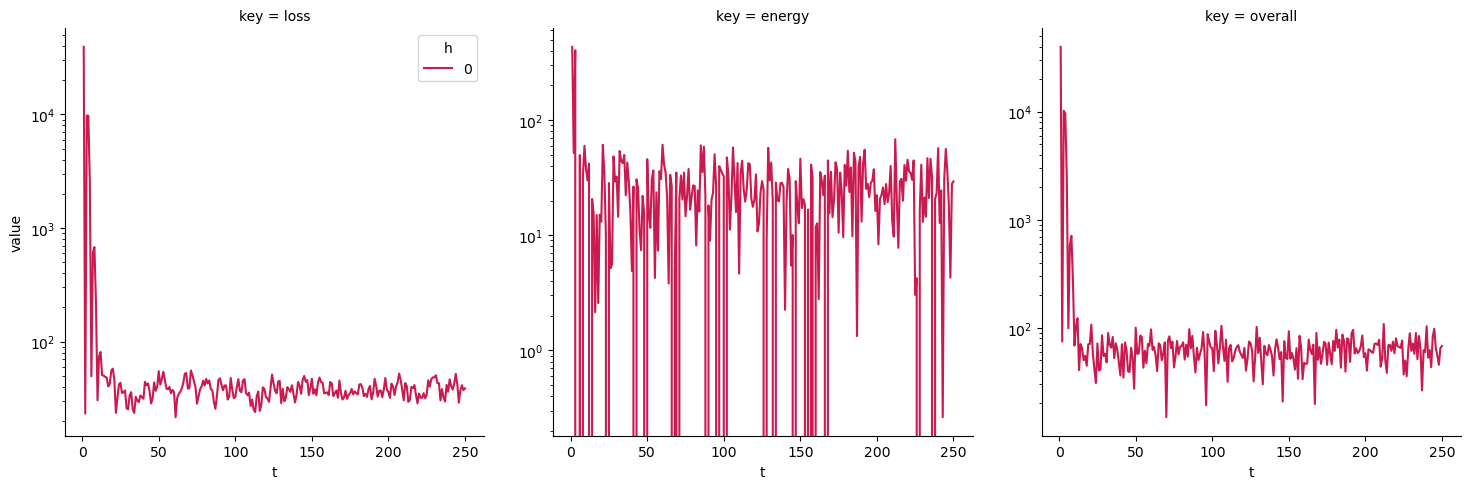

<Figure size 640x480 with 0 Axes>

In [20]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=True, is_return_results_every_t=True) 

### Train the model

Update trainer for learning

In [21]:
training_trainer = pc.PCTrainer(mcpc_model_2nd, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [22]:
# data parameters
mu=1.               # data mean
var=5.              # data variance
batch_size = 256    
n = 150              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [23]:
n_epochs = 3   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")
        

Epoch: 3, Energy: 333.95: 100%|██████████| 150/150 [00:26<00:00,  5.72it/s] 


### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [24]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model_2nd[:],
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn_2nd, energy_fn_kwargs={'lr': lr, 'noise_var': 1., "momentum": momentum}) #sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1.})
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T = 10000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 2.597e+04 | o: 2.597e+04 |:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: -5.604e+02 | o: -5.604e+02 |: 100%|██████████| 10000/10000 [00:43<00:00, 231.01it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\pre

<Figure size 640x480 with 0 Axes>

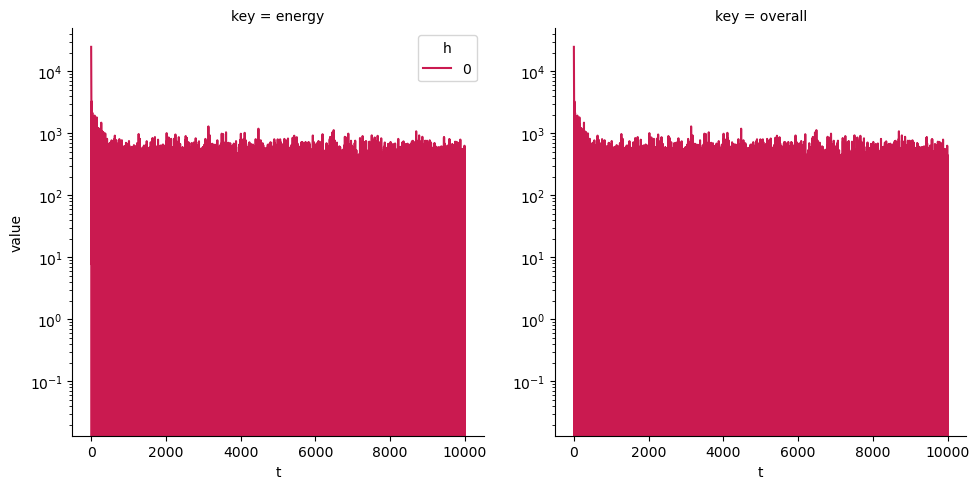

<Figure size 640x480 with 0 Axes>

In [25]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

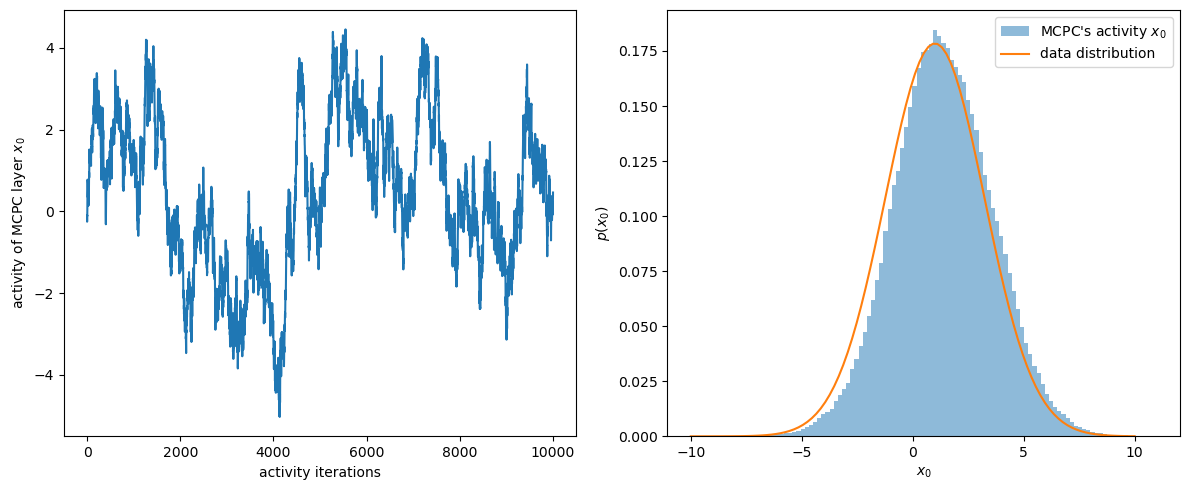

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[4,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=100, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()

In [27]:
print(mcpc_model_2nd[0].bias)
print(mcpc_model_2nd[2].weight)

Parameter containing:
tensor([[0.5614]], requires_grad=True)
Parameter containing:
tensor([[2.0483]], requires_grad=True)


## With pc layers in the middle

Define MCPC model

In [119]:
# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 
    
T_mixing = 100                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 50                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD          # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations


# create MCPC model    
mcpc_model = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1., "var": 1.}),
    nn.Linear(hidden_size, output_size, bias=False),
    pc.PCLayer(sample_x_fn=pc_sample_x_fn, energy_fn=pc_energy_fn, energy_fn_kwargs={"var": 1.}),
)
mcpc_model.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model[0].bias, 0.)
nn.init.constant_(mcpc_model[2].weight, 1.) 

Parameter containing:
tensor([[1.]], requires_grad=True)

Define trainer that manages the inferences and weight updates of the PC models

In [120]:
inference_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/150 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 1.926e+01 | e: -9.752e+01 | o: -7.825e+01 |:   0%|          | 0/150 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| l: 3.168e+00 | e: 1.134e+01 | o: 1.451e+01 |: 100%|██████████| 150/150 [00:00<00:00, 500.68it/s]  
c:\Users\olivi\OneDrive - Nexus365\Proje

<Figure size 640x480 with 0 Axes>

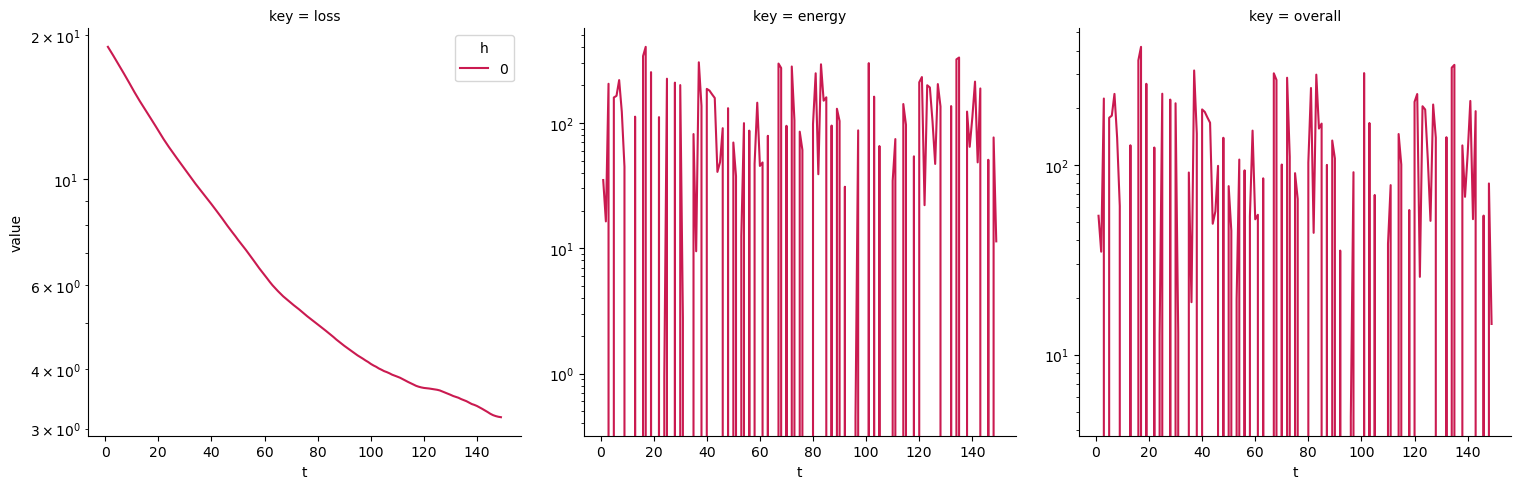

<Figure size 640x480 with 0 Axes>

In [121]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=True, is_return_results_every_t=True) 

### Train the model

Update trainer for learning

In [122]:
training_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [165]:
vars = [1.5, 2, 3, 4, 5, 10]
bias=[]
weight=[]

# data parameters
mu=1.               # data mean
batch_size = 1024    
n = 15              # number of batches
n_epochs = 50   # set number of epochs for training

for var in tqdm(vars):
    nn.init.constant_(mcpc_model[0].bias, 1.)
    nn.init.constant_(mcpc_model[2].weight, 1.) 
    # generate data
    data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

    # train pc model
    energy=[np.inf]       # stored overall energy after each iteration
    for idx_epoch in range(n_epochs):
        for i, y in enumerate(data):
            pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
            output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
    
    bias.append(mcpc_model[0].bias[0,0].item())
    weight.append(mcpc_model[2].weight[0,0].item())

100%|██████████| 6/6 [06:34<00:00, 65.83s/it]


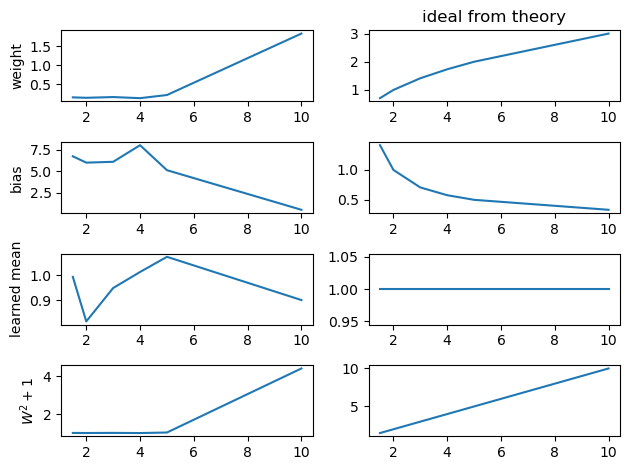

In [225]:
plt.subplot(4,2,1)
plt.plot(vars, weight)
plt.ylabel("weight")
# ideal weights
plt.subplot(4,2,2)
ideal = np.sqrt(np.array(vars)-1)
plt.plot(vars, ideal)
plt.title("ideal from theory")
plt.subplot(4,2,3)
plt.plot(vars,bias)
plt.ylabel("bias")
plt.subplot(4,2,4)
ideal_bias = mu/ideal
plt.plot(vars, ideal_bias)

plt.subplot(4,2,5)
plt.plot(vars, [b*w for (b,w) in zip(bias,weight)])
plt.ylabel("learned mean")
plt.subplot(4,2,6)
plt.plot(vars, [mu for i in range(len(vars))])

plt.subplot(4,2,7)

plt.plot(vars, [w**2 + 1 for (b,w) in zip(bias,weight)])
plt.ylabel(r"$W^2+1$")
plt.subplot(4,2,8)
plt.plot(vars, vars)

plt.tight_layout()


In [163]:
gen_mean=[]
gen_var = []
for (b,w) in zip(bias,weight):

    ## generate samples
    model_generation = nn.Sequential(
        mcpc_model[:],
        pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn,energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1., "var": 1.})
    )
    model_generation.train()
    nn.init.constant_(mcpc_model[0].bias, b)
    nn.init.constant_(mcpc_model[2].weight, w) 

    # setup trainer for generation with large T to get close to the true generative distribution
    generation_trainer = pc.PCTrainer(model_generation, 
        T = 5050, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = {"lr":0.01},
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= []
    )
    # run generation with neural network/dynamics
    pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
    results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)
    # extract activity of PC layer x_0 over time
    x_0 = [x_0 for x_0 in results["outputs"]]
    x_0 = torch.cat(x_0).reshape(-1).detach().numpy()

    gen_mean.append(x_0.mean())
    gen_var.append(x_0.var())

| e: -6.803e+02 | o: -6.803e+02 |: 100%|██████████| 5050/5050 [00:07<00:00, 686.10it/s]
| e: 1.271e+03 | o: 1.271e+03 |: 100%|██████████| 5050/5050 [00:07<00:00, 684.59it/s]  
| e: 9.427e+02 | o: 9.427e+02 |: 100%|██████████| 5050/5050 [00:07<00:00, 661.18it/s]  
| e: 2.976e+02 | o: 2.976e+02 |: 100%|██████████| 5050/5050 [00:07<00:00, 651.80it/s]  
| e: 5.773e+02 | o: 5.773e+02 |: 100%|██████████| 5050/5050 [00:08<00:00, 600.67it/s]  
| e: -7.386e+02 | o: -7.386e+02 |: 100%|██████████| 5050/5050 [00:08<00:00, 586.98it/s]


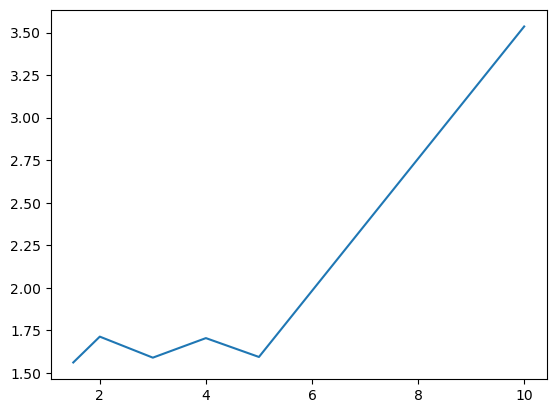

In [164]:
plt.plot(vars, gen_var)

In [117]:
# data parameters
mu=1.               # data mean
var=2.              # data variance
batch_size = 1024    
n = 15              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [118]:
n_epochs = 250   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")
        
    print(f"bias: {mcpc_model[0].bias[0,0].item()}")
    print(f"weight: {mcpc_model[2].weight[0,0].item()}")

Epoch: 1, Energy: 1723.06: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]


bias: 1.5077966451644897
weight: 0.46763086318969727


Epoch: 2, Energy: 233.63: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s] 


bias: 2.002115249633789
weight: 0.42123499512672424


Epoch: 3, Energy: -213.21: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s] 


bias: 2.245448350906372
weight: 0.3929027318954468


Epoch: 4, Energy: 2194.47: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s] 


bias: 2.4003562927246094
weight: 0.3557871878147125


Epoch: 5, Energy: 1381.47: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


bias: 2.5585508346557617
weight: 0.3484083414077759


Epoch: 6, Energy: -1418.02: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


bias: 2.9148683547973633
weight: 0.3351299464702606


Epoch: 7, Energy: 2095.14: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s] 


bias: 3.0644872188568115
weight: 0.3306390345096588


Epoch: 8, Energy: 1879.98: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s] 


bias: 3.0648410320281982
weight: 0.32263076305389404


Epoch: 9, Energy: 110.92: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s] 


bias: 3.127142906188965
weight: 0.30887091159820557


Epoch: 10, Energy: 72.55: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]   


bias: 3.2800581455230713
weight: 0.30136263370513916


Epoch: 11, Energy: 933.72: 100%|██████████| 15/15 [00:02<00:00,  5.52it/s] 


bias: 3.491223096847534
weight: 0.2833305895328522


Epoch: 12, Energy: 3372.67: 100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


bias: 3.6169509887695312
weight: 0.2645665109157562


Epoch: 13, Energy: 557.31: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s] 


bias: 3.550323486328125
weight: 0.2846396565437317


Epoch: 14, Energy: -410.97: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


bias: 3.527374029159546
weight: 0.2834802269935608


Epoch: 15, Energy: 2571.09: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s]


bias: 3.569777488708496
weight: 0.27674880623817444


Epoch: 16, Energy: 703.12: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s] 


bias: 3.3770344257354736
weight: 0.28440263867378235


Epoch: 17, Energy: 1627.36: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]


bias: 3.3241841793060303
weight: 0.28928515315055847


Epoch: 18, Energy: -1697.31: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]


bias: 3.367074489593506
weight: 0.2940727770328522


Epoch: 19, Energy: 503.19: 100%|██████████| 15/15 [00:02<00:00,  5.60it/s] 


bias: 3.509852647781372
weight: 0.2831602692604065


Epoch: 20, Energy: -60.54: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s] 


bias: 3.555302381515503
weight: 0.27253085374832153


Epoch: 21, Energy: 3154.94: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s]


bias: 3.6991522312164307
weight: 0.2665514051914215


Epoch: 22, Energy: 2442.16: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s] 


bias: 3.7240347862243652
weight: 0.26446732878685


Epoch: 23, Energy: 4.24: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s]   


bias: 3.7110257148742676
weight: 0.2718281149864197


Epoch: 24, Energy: 4023.42: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


bias: 3.6862053871154785
weight: 0.26495179533958435


Epoch: 25, Energy: 585.72: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s] 


bias: 3.6799373626708984
weight: 0.26478680968284607


Epoch: 26, Energy: 986.93: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s] 


bias: 3.5822184085845947
weight: 0.2776898741722107


Epoch: 27, Energy: 961.98: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s]  


bias: 3.8136489391326904
weight: 0.25154271721839905


Epoch: 28, Energy: 1257.87: 100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


bias: 4.202938079833984
weight: 0.231430321931839


Epoch: 29, Energy: 1989.11: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s] 


bias: 4.503414630889893
weight: 0.20978853106498718


Epoch: 30, Energy: 874.84: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]  


bias: 4.7364301681518555
weight: 0.20181146264076233


Epoch: 31, Energy: 2498.1: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]  


bias: 4.666596412658691
weight: 0.20892751216888428


Epoch: 32, Energy: 516.93: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s]  


bias: 4.777519702911377
weight: 0.19698913395404816


Epoch: 33, Energy: 1048.92: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


bias: 4.795299053192139
weight: 0.20350131392478943


Epoch: 34, Energy: -1350.57: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


bias: 4.710298538208008
weight: 0.2046354115009308


Epoch: 35, Energy: -1320.34: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


bias: 4.649013519287109
weight: 0.21668821573257446


Epoch: 36, Energy: 196.96: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s]  


bias: 4.5637383460998535
weight: 0.21323738992214203


Epoch: 37, Energy: 3035.16: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]


bias: 4.451427459716797
weight: 0.21749703586101532


Epoch: 38, Energy: 813.41: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s] 


bias: 4.298822402954102
weight: 0.2321835309267044


Epoch: 39, Energy: 1551.96: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s]


bias: 4.260737895965576
weight: 0.2287411093711853


Epoch: 40, Energy: -236.01: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


bias: 4.261513710021973
weight: 0.23401223123073578


Epoch: 41, Energy: 2307.83: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s] 


bias: 4.385385036468506
weight: 0.2281152307987213


Epoch: 42, Energy: 3264.76: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s] 


bias: 4.535688877105713
weight: 0.21264399588108063


Epoch: 43, Energy: 715.34: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s] 


bias: 4.805383682250977
weight: 0.20463447272777557


Epoch: 44, Energy: 2709.8: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s]  


bias: 4.958615779876709
weight: 0.19429796934127808


Epoch: 45, Energy: -2403.53: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


bias: 5.0897417068481445
weight: 0.18836547434329987


Epoch: 46, Energy: 846.26: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]  


bias: 5.115868091583252
weight: 0.18476669490337372


Epoch: 47, Energy: -1183.33: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


bias: 5.127852916717529
weight: 0.18808972835540771


Epoch: 48, Energy: -1132.29: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


bias: 5.072224140167236
weight: 0.19422543048858643


Epoch: 49, Energy: -281.47: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


bias: 5.08300256729126
weight: 0.19163717329502106


Epoch: 50, Energy: 2256.39: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s] 


bias: 5.005672454833984
weight: 0.19662515819072723


Epoch: 51, Energy: -1358.96: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


bias: 4.941638469696045
weight: 0.19014708697795868


Epoch: 52, Energy: 3624.55: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s] 


bias: 5.186795711517334
weight: 0.18750937283039093


Epoch: 53, Energy: 575.05: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]  


bias: 5.335525989532471
weight: 0.17948205769062042


Epoch: 54, Energy: 1840.84: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s] 


bias: 5.500616550445557
weight: 0.1770402044057846


Epoch: 55, Energy: 2991.95: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s] 


bias: 5.625477313995361
weight: 0.16691002249717712


Epoch: 56, Energy: 2951.07: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


bias: 5.487366676330566
weight: 0.17630963027477264


Epoch: 57, Energy: -684.18: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s] 


bias: 5.451517581939697
weight: 0.17577418684959412


Epoch: 58, Energy: 370.58: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s] 


bias: 5.3416428565979
weight: 0.18482953310012817


Epoch: 59, Energy: 128.73: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s] 


bias: 5.174516677856445
weight: 0.18965037167072296


Epoch: 60, Energy: 1793.53: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s] 


bias: 5.334789276123047
weight: 0.1835452765226364


Epoch: 61, Energy: 78.01: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]   


bias: 5.406461238861084
weight: 0.17697247862815857


Epoch: 62, Energy: 1673.75: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


bias: 5.491685390472412
weight: 0.1797591894865036


Epoch: 63, Energy: 1257.66: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s] 


bias: 5.558312892913818
weight: 0.16828422248363495


Epoch: 64, Energy: -916.23: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


bias: 5.635902404785156
weight: 0.16648732125759125


Epoch: 65, Energy: 3634.01: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


bias: 5.8054633140563965
weight: 0.17074410617351532


Epoch: 66, Energy: 1467.9: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s]  


bias: 6.070761203765869
weight: 0.15375925600528717


Epoch: 67, Energy: 330.78: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s]  


bias: 6.058681964874268
weight: 0.1543104499578476


Epoch: 68, Energy: 2384.85: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


bias: 6.0890793800354
weight: 0.1581949144601822


Epoch: 69, Energy: 550.54: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]  


bias: 6.109195709228516
weight: 0.15621066093444824


Epoch: 70, Energy: 3919.89: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s] 


bias: 6.0356059074401855
weight: 0.1554936021566391


Epoch: 71, Energy: -3945.02: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


bias: 5.817603588104248
weight: 0.16752803325653076


Epoch: 72, Energy: -2448.94: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


bias: 5.658796787261963
weight: 0.17356906831264496


Epoch: 73, Energy: 1317.21: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


bias: 5.739907741546631
weight: 0.1685664802789688


Epoch: 74, Energy: -3058.24: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


bias: 5.717341899871826
weight: 0.17316752672195435


Epoch: 75, Energy: 3992.77: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s] 


bias: 5.767025470733643
weight: 0.17133274674415588


Epoch: 76, Energy: 351.15: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s]  


bias: 5.923556327819824
weight: 0.16424980759620667


Epoch: 77, Energy: -1074.35: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


bias: 6.097279071807861
weight: 0.15425725281238556


Epoch: 78, Energy: 1139.13: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


bias: 6.176360607147217
weight: 0.15904226899147034


Epoch: 79, Energy: 6718.54: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


bias: 6.250450134277344
weight: 0.1534435749053955


Epoch: 80, Energy: 2571.06: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s] 


bias: 6.44796085357666
weight: 0.1459110528230667


Epoch: 81, Energy: 1506.59: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


bias: 6.431917190551758
weight: 0.1474493145942688


Epoch: 82, Energy: 819.99: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]  


bias: 6.444634437561035
weight: 0.14956822991371155


Epoch: 83, Energy: -1097.58: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


bias: 6.342823028564453
weight: 0.1506965160369873


Epoch: 84, Energy: 370.99: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s]  


bias: 6.362473964691162
weight: 0.1530807465314865


Epoch: 85, Energy: 2568.25: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s] 


bias: 6.204858303070068
weight: 0.15513570606708527


Epoch: 86, Energy: -3394.23: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


bias: 6.007301330566406
weight: 0.159295916557312


Epoch: 87, Energy: 4194.87: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s] 


bias: 5.804896354675293
weight: 0.17094628512859344


Epoch: 88, Energy: -217.56: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s] 


bias: 5.666710376739502
weight: 0.17392827570438385


Epoch: 89, Energy: 360.73: 100%|██████████| 15/15 [00:02<00:00,  6.20it/s]  


bias: 5.674717903137207
weight: 0.17765484750270844


Epoch: 90, Energy: 2078.77: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s] 


bias: 5.7087907791137695
weight: 0.1711602807044983


Epoch: 91, Energy: -3291.44: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s]


bias: 5.84574031829834
weight: 0.17183326184749603


Epoch: 92, Energy: 1832.67: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s] 


bias: 5.93881368637085
weight: 0.16137146949768066


Epoch: 93, Energy: 2974.27: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s] 


bias: 6.157931804656982
weight: 0.15950913727283478


Epoch: 94, Energy: 375.38: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s] 


bias: 6.360894203186035
weight: 0.15073785185813904


Epoch: 95, Energy: -1967.07: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s]


bias: 6.591761589050293
weight: 0.14307570457458496


Epoch: 96, Energy: -658.17: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s] 


bias: 6.878766059875488
weight: 0.14047765731811523


Epoch: 97, Energy: -1323.53: 100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


bias: 6.893058776855469
weight: 0.1358896642923355


Epoch: 98, Energy: 6900.28: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s] 


bias: 7.009780406951904
weight: 0.13278760015964508


Epoch: 99, Energy: -1356.34: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s]


bias: 7.0339789390563965
weight: 0.12835811078548431


Epoch: 100, Energy: 132.27: 100%|██████████| 15/15 [00:02<00:00,  5.51it/s]  


bias: 6.906841278076172
weight: 0.13166216015815735


Epoch: 101, Energy: 3436.42: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s] 


bias: 6.9387102127075195
weight: 0.13880090415477753


Epoch: 102, Energy: 2462.44: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s] 


bias: 6.757933139801025
weight: 0.1393231600522995


Epoch: 103, Energy: -6806.06: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


bias: 6.871843338012695
weight: 0.13819102942943573


Epoch: 104, Energy: 444.72: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]  


bias: 6.835483074188232
weight: 0.14175640046596527


Epoch: 105, Energy: -4493.96: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


bias: 6.797180652618408
weight: 0.14070899784564972


Epoch: 106, Energy: -2991.21: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


bias: 6.769575119018555
weight: 0.14459654688835144


Epoch: 107, Energy: 90.39: 100%|██████████| 15/15 [00:41<00:00,  2.74s/it]   


bias: 6.791044235229492
weight: 0.14326690137386322


Epoch: 108, Energy: 183.28: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]  


bias: 6.689031600952148
weight: 0.14309966564178467


Epoch: 109, Energy: 2621.57: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s] 


bias: 6.571720123291016
weight: 0.14919504523277283


Epoch: 110, Energy: 2205.21: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s] 


bias: 6.4076666831970215
weight: 0.1480795443058014


Epoch: 111, Energy: -3995.85: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


bias: 6.355340480804443
weight: 0.15423010289669037


Epoch: 112, Energy: 1903.44: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


bias: 6.40308952331543
weight: 0.15567274391651154


Epoch: 113, Energy: 557.35: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]  


bias: 6.560540199279785
weight: 0.1474056988954544


Epoch: 114, Energy: 2675.92: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s] 


bias: 6.622990131378174
weight: 0.14570173621177673


Epoch: 115, Energy: 2375.88: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s] 


bias: 6.731594562530518
weight: 0.14485551416873932


Epoch: 116, Energy: -1357.73: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


bias: 6.6338701248168945
weight: 0.14839059114456177


Epoch: 117, Energy: 8028.19: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s] 


bias: 6.626833438873291
weight: 0.14624916017055511


Epoch: 118, Energy: 2771.57: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


bias: 6.767105579376221
weight: 0.14350569248199463


Epoch: 119, Energy: -1186.68: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]


bias: 6.8759050369262695
weight: 0.13906103372573853


Epoch: 120, Energy: -2601.46: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


bias: 7.051834583282471
weight: 0.13701240718364716


Epoch: 121, Energy: 617.52: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]  


bias: 6.991114139556885
weight: 0.13741444051265717


Epoch: 122, Energy: 3978.83: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s] 


bias: 6.945749282836914
weight: 0.13772259652614594


Epoch: 123, Energy: 827.42: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s]  


bias: 7.077615737915039
weight: 0.13694000244140625


Epoch: 124, Energy: 6762.17: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


bias: 7.189391613006592
weight: 0.1317315548658371


Epoch: 125, Energy: 9377.9: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]  


bias: 7.219725608825684
weight: 0.12980623543262482


Epoch: 126, Energy: 2197.54: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s] 


bias: 7.202335357666016
weight: 0.13169951736927032


Epoch: 127, Energy: 2414.07: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s] 


bias: 7.190964698791504
weight: 0.1300777792930603


Epoch: 128, Energy: -2706.41: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]


bias: 7.1621479988098145
weight: 0.13446441292762756


Epoch: 129, Energy: -553.59: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s] 


bias: 7.139516830444336
weight: 0.13460476696491241


Epoch: 130, Energy: -924.34: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s] 


bias: 6.985018730163574
weight: 0.13867196440696716


Epoch: 131, Energy: -1920.44: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


bias: 6.790805339813232
weight: 0.1430974155664444


Epoch: 132, Energy: 10857.49: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


bias: 6.687331199645996
weight: 0.1466463953256607


Epoch: 133, Energy: -3862.08: 100%|██████████| 15/15 [00:02<00:00,  6.21it/s]


bias: 6.4773993492126465
weight: 0.155781552195549


Epoch: 134, Energy: -2052.89: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


bias: 6.318231582641602
weight: 0.15658333897590637


Epoch: 135, Energy: -1538.65: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


bias: 6.254528045654297
weight: 0.16084250807762146


Epoch: 136, Energy: 377.11: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s] 


bias: 6.292350769042969
weight: 0.15821748971939087


Epoch: 137, Energy: -3557.75: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s]


bias: 6.584508895874023
weight: 0.15000507235527039


Epoch: 138, Energy: 1649.06: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s] 


bias: 6.681446075439453
weight: 0.14893734455108643


Epoch: 139, Energy: -2666.14: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


bias: 6.762918472290039
weight: 0.14324185252189636


Epoch: 140, Energy: -1200.78: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


bias: 6.784821033477783
weight: 0.14531821012496948


Epoch: 141, Energy: -462.78: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s] 


bias: 6.722296714782715
weight: 0.14314334094524384


Epoch: 142, Energy: 1927.28: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


bias: 6.602891445159912
weight: 0.14872799813747406


Epoch: 143, Energy: 6.08: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]    


bias: 6.407086372375488
weight: 0.1561107486486435


Epoch: 144, Energy: 1226.92: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s] 


bias: 6.397017478942871
weight: 0.1524505764245987


Epoch: 145, Energy: 2025.02: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s] 


bias: 6.390780448913574
weight: 0.15527084469795227


Epoch: 146, Energy: 7251.38: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


bias: 6.4192728996276855
weight: 0.15473152697086334


Epoch: 147, Energy: 1526.25: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s]


bias: 6.352389812469482
weight: 0.15490321815013885


Epoch: 148, Energy: -2357.56: 100%|██████████| 15/15 [00:02<00:00,  5.87it/s]


bias: 6.327502727508545
weight: 0.15639719367027283


Epoch: 149, Energy: 297.17: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s]  


bias: 6.3911542892456055
weight: 0.1517837941646576


Epoch: 150, Energy: -723.23: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s]


bias: 6.451528549194336
weight: 0.15281806886196136


Epoch: 151, Energy: 1753.84: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s] 


bias: 6.260493278503418
weight: 0.15740960836410522


Epoch: 152, Energy: 4156.19: 100%|██████████| 15/15 [00:02<00:00,  6.04it/s] 


bias: 6.090879917144775
weight: 0.16160883009433746


Epoch: 153, Energy: -2286.89: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s]


bias: 5.912902355194092
weight: 0.16668935120105743


Epoch: 154, Energy: 2661.15: 100%|██████████| 15/15 [00:02<00:00,  6.19it/s] 


bias: 5.743730545043945
weight: 0.1753600835800171


Epoch: 155, Energy: -268.11: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s] 


bias: 5.602468013763428
weight: 0.17915186285972595


Epoch: 156, Energy: 1125.38: 100%|██████████| 15/15 [00:02<00:00,  6.21it/s] 


bias: 5.612297534942627
weight: 0.18028883635997772


Epoch: 157, Energy: 5389.46: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s] 


bias: 5.653425216674805
weight: 0.17573627829551697


Epoch: 158, Energy: -2080.18: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


bias: 5.487032413482666
weight: 0.18268604576587677


Epoch: 159, Energy: -796.92: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s]


bias: 5.413443088531494
weight: 0.18672984838485718


Epoch: 160, Energy: -748.18: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s] 


bias: 5.334238052368164
weight: 0.18883907794952393


Epoch: 161, Energy: 205.04: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s] 


bias: 5.372026443481445
weight: 0.18887129426002502


Epoch: 162, Energy: 1091.06: 100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


bias: 5.415210247039795
weight: 0.1854320466518402


Epoch: 163, Energy: -339.86: 100%|██████████| 15/15 [00:02<00:00,  5.46it/s] 


bias: 5.571805477142334
weight: 0.18165206909179688


Epoch: 164, Energy: -1069.34: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


bias: 5.66014289855957
weight: 0.173172727227211


Epoch: 165, Energy: 274.45: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]  


bias: 5.796941757202148
weight: 0.17050564289093018


Epoch: 166, Energy: 770.69: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]  


bias: 5.83612060546875
weight: 0.17079481482505798


Epoch: 167, Energy: -1093.01: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


bias: 5.901241779327393
weight: 0.16398601233959198


Epoch: 168, Energy: -691.28: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


bias: 6.045257568359375
weight: 0.1640230417251587


Epoch: 169, Energy: -6016.54: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


bias: 6.2026543617248535
weight: 0.15690793097019196


Epoch: 170, Energy: 4360.02: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s] 


bias: 6.141483783721924
weight: 0.1623450517654419


Epoch: 171, Energy: -2657.69: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


bias: 6.137829303741455
weight: 0.15843766927719116


Epoch: 172, Energy: 774.28: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s] 


bias: 6.205370903015137
weight: 0.15953496098518372


Epoch: 173, Energy: 3800.88: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s] 


bias: 6.294792175292969
weight: 0.15641337633132935


Epoch: 174, Energy: 4399.42: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s] 


bias: 6.275832176208496
weight: 0.15497995913028717


Epoch: 175, Energy: 489.78: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s]  


bias: 6.240806579589844
weight: 0.15648153424263


Epoch: 176, Energy: 2636.67: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s] 


bias: 6.351528167724609
weight: 0.1546960473060608


Epoch: 177, Energy: 791.37: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]  


bias: 6.468477249145508
weight: 0.14992041885852814


Epoch: 178, Energy: 2059.63: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s] 


bias: 6.512943744659424
weight: 0.1478041112422943


Epoch: 179, Energy: -384.47: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


bias: 6.807297229766846
weight: 0.14150668680667877


Epoch: 180, Energy: 2450.54: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s]


bias: 6.821171760559082
weight: 0.14288118481636047


Epoch: 181, Energy: -1440.96: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


bias: 6.753437042236328
weight: 0.1393052339553833


Epoch: 182, Energy: 953.24: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s]  


bias: 6.922066688537598
weight: 0.13699720799922943


Epoch: 183, Energy: -1143.05: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


bias: 7.0100812911987305
weight: 0.13965997099876404


Epoch: 184, Energy: 605.67: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s]  


bias: 7.11051082611084
weight: 0.13072913885116577


Epoch: 185, Energy: 2965.54: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


bias: 7.268944263458252
weight: 0.1283421516418457


Epoch: 186, Energy: -926.95: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s] 


bias: 7.418881893157959
weight: 0.1266147941350937


Epoch: 187, Energy: 4908.13: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s] 


bias: 7.467382907867432
weight: 0.12394912540912628


Epoch: 188, Energy: -3024.36: 100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


bias: 7.623797416687012
weight: 0.12241825461387634


Epoch: 189, Energy: 1355.83: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


bias: 7.604509353637695
weight: 0.12139599025249481


Epoch: 190, Energy: 5413.49: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s] 


bias: 7.674189567565918
weight: 0.12008067965507507


Epoch: 191, Energy: -13977.38: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


bias: 7.62526273727417
weight: 0.1239684522151947


Epoch: 192, Energy: 10185.94: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


bias: 7.597128868103027
weight: 0.12341569364070892


Epoch: 193, Energy: 7741.53: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s] 


bias: 7.570741653442383
weight: 0.12433979660272598


Epoch: 194, Energy: -4759.4: 100%|██████████| 15/15 [00:41<00:00,  2.74s/it] 


bias: 7.553072929382324
weight: 0.12562693655490875


Epoch: 195, Energy: 2112.81: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s] 


bias: 7.491958141326904
weight: 0.12679703533649445


Epoch: 196, Energy: 251.89: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s] 


bias: 7.205366611480713
weight: 0.13517455756664276


Epoch: 197, Energy: 241.77: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]  


bias: 7.224328517913818
weight: 0.13665753602981567


Epoch: 198, Energy: 3509.45: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s]


bias: 7.245932102203369
weight: 0.13274022936820984


Epoch: 199, Energy: 2805.95: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s] 


bias: 7.213703632354736
weight: 0.1350540667772293


Epoch: 200, Energy: 8389.29: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s] 


bias: 7.489765644073486
weight: 0.13097573816776276


Epoch: 201, Energy: 2763.71: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s] 


bias: 7.524165153503418
weight: 0.12179429829120636


Epoch: 202, Energy: 8334.85: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s] 


bias: 7.25682258605957
weight: 0.13474975526332855


Epoch: 203, Energy: -7022.52: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


bias: 7.316354751586914
weight: 0.1307615041732788


Epoch: 204, Energy: 1579.34: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s] 


bias: 7.23582124710083
weight: 0.13450855016708374


Epoch: 205, Energy: 1266.26: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


bias: 7.298598766326904
weight: 0.13146117329597473


Epoch: 206, Energy: 5467.84: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s] 


bias: 7.249901294708252
weight: 0.13225291669368744


Epoch: 207, Energy: -1646.17: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


bias: 7.20356559753418
weight: 0.13572455942630768


Epoch: 208, Energy: 3141.36: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]


bias: 7.280369758605957
weight: 0.13305442035198212


Epoch: 209, Energy: 2488.37: 100%|██████████| 15/15 [00:02<00:00,  6.09it/s] 


bias: 7.379522800445557
weight: 0.13037681579589844


Epoch: 210, Energy: -5029.88: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]


bias: 7.448563575744629
weight: 0.12876956164836884


Epoch: 211, Energy: 1957.59: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s] 


bias: 7.453952312469482
weight: 0.12929260730743408


Epoch: 212, Energy: -3092.73: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s]


bias: 7.2386603355407715
weight: 0.13314348459243774


Epoch: 213, Energy: -1186.41: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s]


bias: 7.1083807945251465
weight: 0.1381572037935257


Epoch: 214, Energy: 3440.23: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s] 


bias: 7.050039768218994
weight: 0.14067569375038147


Epoch: 215, Energy: 5496.91: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s] 


bias: 7.07805061340332
weight: 0.13747046887874603


Epoch: 216, Energy: 613.08: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s]  


bias: 7.170645236968994
weight: 0.1367958039045334


Epoch: 217, Energy: 1920.71: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s] 


bias: 7.215823650360107
weight: 0.1360541582107544


Epoch: 218, Energy: -5171.7: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s] 


bias: 7.286564826965332
weight: 0.13306142389774323


Epoch: 219, Energy: 5128.72: 100%|██████████| 15/15 [00:02<00:00,  5.56it/s] 


bias: 7.288092613220215
weight: 0.13327640295028687


Epoch: 220, Energy: 1.64: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s]    


bias: 7.057164669036865
weight: 0.1374983787536621


Epoch: 221, Energy: -694.73: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s] 


bias: 6.8993306159973145
weight: 0.14133904874324799


Epoch: 222, Energy: 1088.56: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s] 


bias: 6.939632892608643
weight: 0.14189057052135468


Epoch: 223, Energy: 5752.36: 100%|██████████| 15/15 [00:02<00:00,  5.16it/s] 


bias: 7.063803195953369
weight: 0.13882796466350555


Epoch: 224, Energy: -2110.38: 100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


bias: 7.152557849884033
weight: 0.1357794553041458


Epoch: 225, Energy: -2064.84: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]


bias: 7.116609573364258
weight: 0.13937757909297943


Epoch: 226, Energy: 2780.75: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s] 


bias: 7.108240604400635
weight: 0.13741663098335266


Epoch: 227, Energy: -40.73: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s]  


bias: 7.0009965896606445
weight: 0.13883386552333832


Epoch: 228, Energy: 4179.31: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s] 


bias: 6.814228534698486
weight: 0.14666393399238586


Epoch: 229, Energy: 9409.22: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s]


bias: 6.425502300262451
weight: 0.15278537571430206


Epoch: 230, Energy: 2472.97: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s] 


bias: 6.185605525970459
weight: 0.1636771559715271


Epoch: 231, Energy: -3210.88: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


bias: 6.053577423095703
weight: 0.16098512709140778


Epoch: 232, Energy: -140.06: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


bias: 6.00863790512085
weight: 0.167597234249115


Epoch: 233, Energy: 275.62: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s]  


bias: 6.10759162902832
weight: 0.16611817479133606


Epoch: 234, Energy: -4321.95: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s]


bias: 6.085324764251709
weight: 0.1647142916917801


Epoch: 235, Energy: -1840.4: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s] 


bias: 5.888549327850342
weight: 0.1710476577281952


Epoch: 236, Energy: -1254.49: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


bias: 5.734290599822998
weight: 0.1759815514087677


Epoch: 237, Energy: -4791.85: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


bias: 5.598173141479492
weight: 0.18232716619968414


Epoch: 238, Energy: 3105.5: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]  


bias: 5.504388809204102
weight: 0.18431389331817627


Epoch: 239, Energy: 1138.36: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s] 


bias: 5.659898281097412
weight: 0.1818503886461258


Epoch: 240, Energy: 662.08: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]  


bias: 5.7317609786987305
weight: 0.17821572721004486


Epoch: 241, Energy: 4557.73: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s] 


bias: 5.688772678375244
weight: 0.17664417624473572


Epoch: 242, Energy: 493.33: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s] 


bias: 5.727175712585449
weight: 0.1780693084001541


Epoch: 243, Energy: 1620.59: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s] 


bias: 5.767474174499512
weight: 0.17500072717666626


Epoch: 244, Energy: 5007.84: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s] 


bias: 5.64973783493042
weight: 0.18037375807762146


Epoch: 245, Energy: -1865.05: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


bias: 5.524099826812744
weight: 0.181716650724411


Epoch: 246, Energy: -3338.69: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


bias: 5.382774353027344
weight: 0.18816013634204865


Epoch: 247, Energy: -553.02: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s] 


bias: 5.292413234710693
weight: 0.18952660262584686


Epoch: 248, Energy: 4508.26: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


bias: 5.429498195648193
weight: 0.18956373631954193


Epoch: 249, Energy: -682.41: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s] 


bias: 5.433224678039551
weight: 0.18925291299819946


Epoch: 250, Energy: 1517.45: 100%|██████████| 15/15 [00:03<00:00,  4.99it/s] 

bias: 5.439962863922119
weight: 0.1852264106273651


### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [18]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model[:],
    # pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1., "var": 1.}) #sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1.})
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T = 10000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = {"lr":0.03},
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 1.374e+02 | o: 1.374e+02 |:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: -1.850e+02 | o: -1.850e+02 |: 100%|██████████| 10000/10000 [00:19<00:00, 525.70it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\pre

<Figure size 640x480 with 0 Axes>

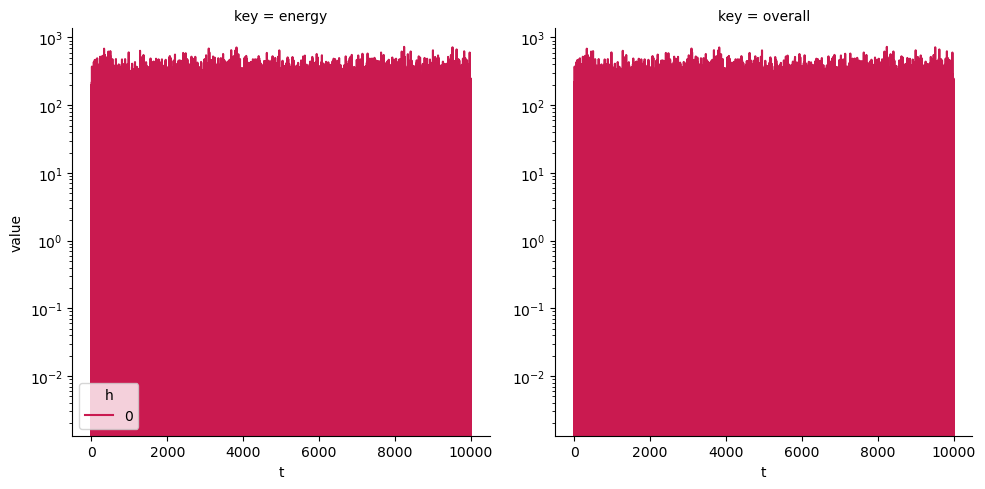

<Figure size 640x480 with 0 Axes>

In [19]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

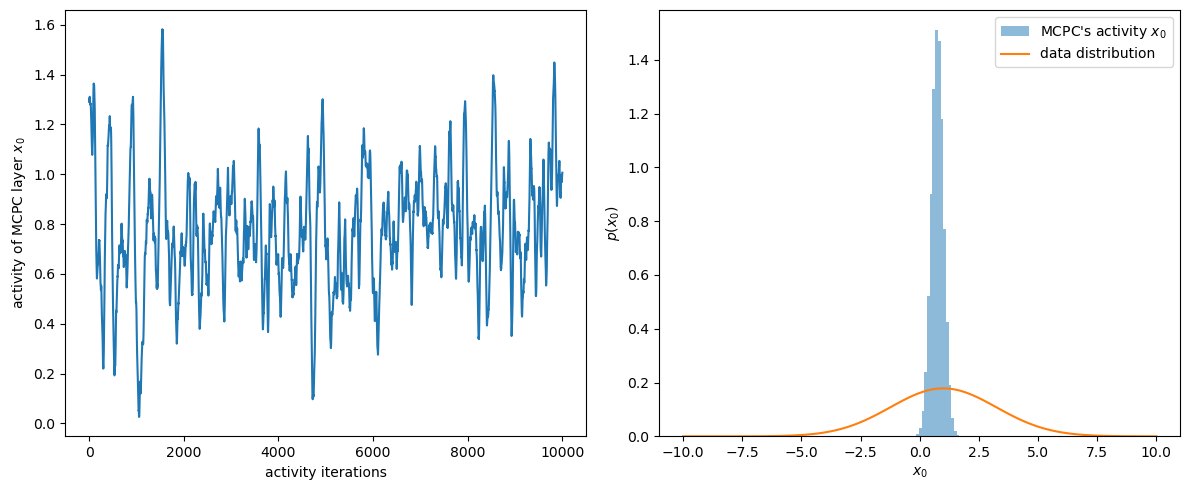

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[4,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=20, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()

In [21]:
print(mcpc_model[0].bias)
print(mcpc_model[2].weight)
print(mcpc_model[4].weight)

Parameter containing:
tensor([[2.0768]], requires_grad=True)
Parameter containing:
tensor([[0.0517]], requires_grad=True)
Parameter containing:
tensor([[6.9822]], requires_grad=True)


## Adam optimiser for inference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import predictive_coding as pc

Define utility functions

In [400]:
# This function define the loss function of the input layer of the model. 
# The loss function of the other layers is define in the model definition.
def fe_fn(output, _target):
    return 0.5*(output - _target).pow(2).sum()

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(torch.Tensor(1,out_features), requires_grad=True)

        # Initialize bias
        nn.init.xavier_normal_(self.bias)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same

# function to initialize the activity of latent layers before inference
def sample_x_fn(inputs):
    return torch.randn_like(inputs['mu']) + inputs['mu'].detach().clone()

# function to add noise to the inference dynamics of the PC layers
def random_step(t, _trainer, var=2.):
    """
        var: sets the variance of the noise.
    """
    xs = _trainer.get_model_xs()
    optimizer = _trainer.get_optimizer_x()
    for x in xs:
        x.grad.normal_(0.,np.sqrt(var/optimizer.defaults['lr']))
    optimizer.step()

def mcpc_energy_fn(inputs, lr, noise_var, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var + np.sqrt(noise_var)/lr*torch.randn_like(inputs['mu'])*inputs['x']

def pc_energy_fn(inputs, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var

def pc_sample_x_fn(inputs):
    return inputs['mu'].detach().clone()


Define MCPC model

In [440]:
# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 
    
T_mixing = 1000                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 50                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.Adam          # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1, 'betas':(0.9, 0.999)}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations


# create MCPC model    
mcpc_model = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 2., "var": 1.}),
    nn.Linear(hidden_size, output_size, bias=False),
        pc.PCLayer(sample_x_fn=pc_sample_x_fn, energy_fn=pc_energy_fn, energy_fn_kwargs={"var": 1.}),

)
mcpc_model.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model[0].bias, 1.)
nn.init.constant_(mcpc_model[2].weight, 1.) 

Parameter containing:
tensor([[1.]], requires_grad=True)

Define trainer that manages the inferences and weight updates of the PC models

In [441]:
inference_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/1050 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 2.855e+01 | e: 7.941e+01 | o: 1.080e+02 |:   0%|          | 0/1050 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| l: 2.555e+00 | e: -2.023e+02 | o: -1.997e+02 |: 100%|██████████| 1050/1050 [00:01<00:00, 751.05it/s]
c:\Users\olivi\OneDrive - Nexus365\Pro

<Figure size 640x480 with 0 Axes>

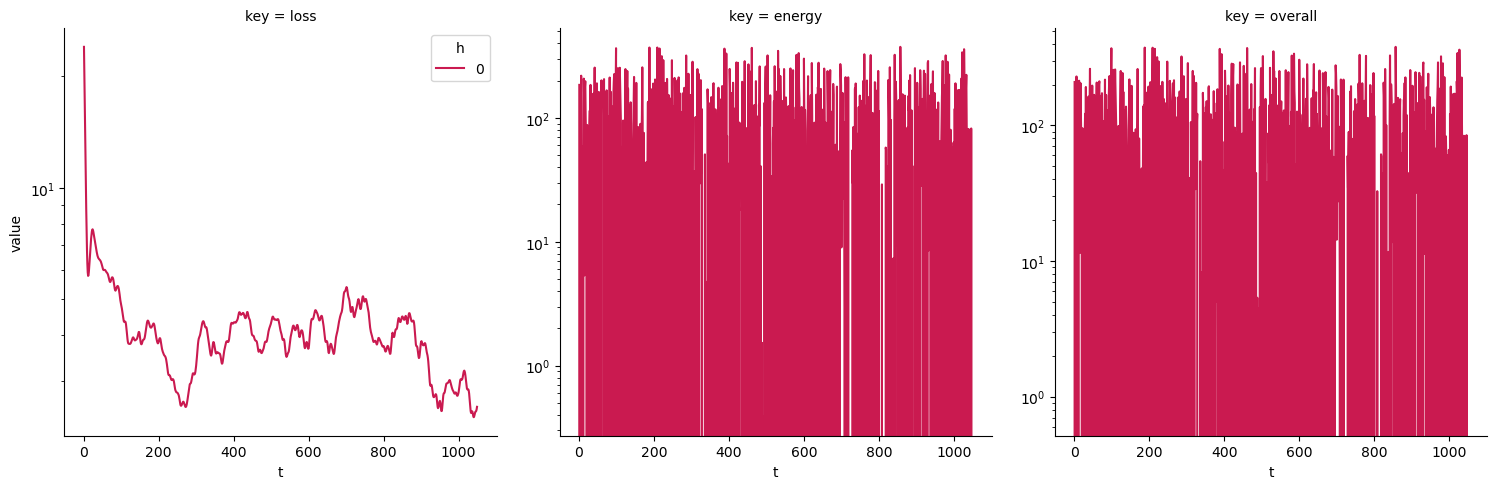

<Figure size 640x480 with 0 Axes>

In [442]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=True, is_return_results_every_t=True) 

### Train the model

Update trainer for learning

In [443]:
training_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [444]:
# data parameters
mu=1.               # data mean
var=2.              # data variance
batch_size = 256    
n = 150              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [445]:
n_epochs = 5   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")

    print(mcpc_model[0].bias)
    print(mcpc_model[2].weight)
        

Epoch: 1, Energy: -176.49: 100%|██████████| 150/150 [01:14<00:00,  2.01it/s]


Parameter containing:
tensor([[1.2228]], requires_grad=True)
Parameter containing:
tensor([[0.9214]], requires_grad=True)


Epoch: 2, Energy: 421.67: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s] 


Parameter containing:
tensor([[1.0538]], requires_grad=True)
Parameter containing:
tensor([[0.9846]], requires_grad=True)


Epoch: 3, Energy: 660.04:   7%|▋         | 10/150 [00:05<01:13,  1.91it/s]


KeyboardInterrupt: 

### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [449]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model[:],
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T =  5000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 7.169e+02 | o: 7.169e+02 |:   0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: 1.354e+03 | o: 1.354e+03 |: 100%|██████████| 5000/5000 [00:07<00:00, 711.67it/s]  
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predict

<Figure size 640x480 with 0 Axes>

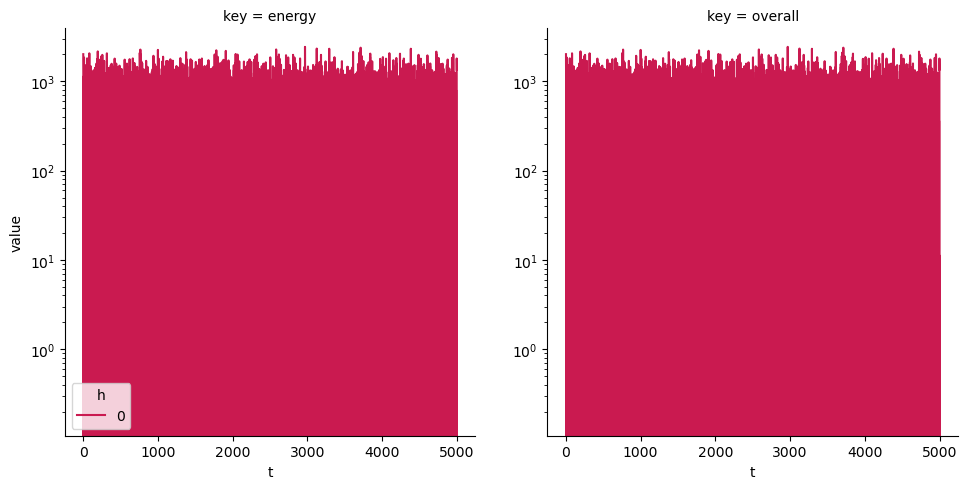

<Figure size 640x480 with 0 Axes>

In [450]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(1000, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

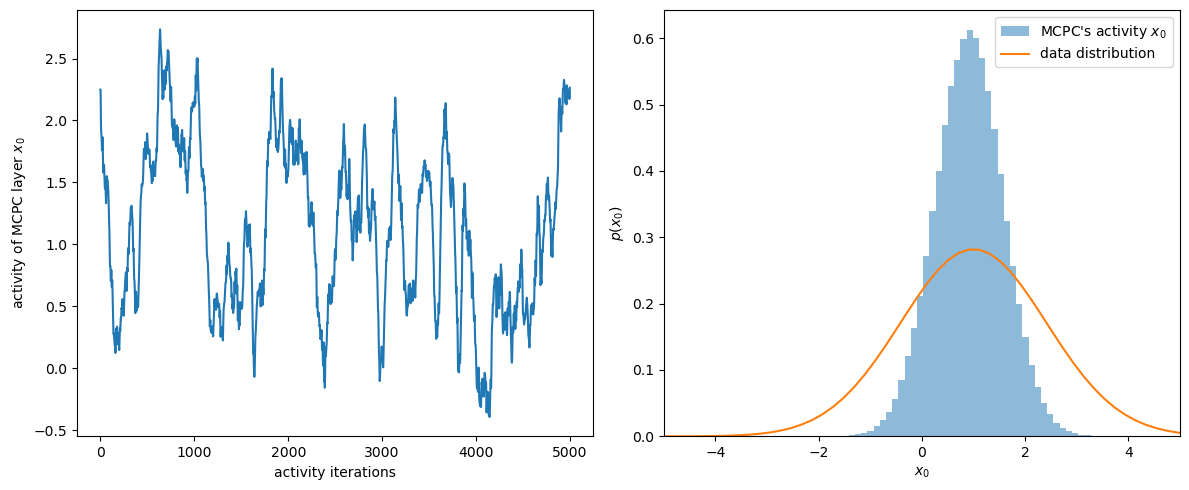

In [451]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[0,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=50, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.xlim(-5,5)
plt.legend()
plt.tight_layout()

In [ ]:
print(mcpc_model[0].bias)
print(mcpc_model[2].weight)

Parameter containing:
tensor([[0.2451]], requires_grad=True)
Parameter containing:
tensor([[5.2744]], requires_grad=True)


### modified optimiser for Langevin dynamics

In [18]:
class SGDLD(optim.SGD):
    def __init__(self, params, lr=0, weight_decay=0, noise_var=1.):
        super(SGDLD, self).__init__(params, lr, weight_decay)
        self.noise_var = noise_var

    def step(self, closure=None):
        super(SGDLD, self).step(closure)

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data.add_(np.sqrt(2*self.noise_var*group['lr'])*torch.randn_like(p))

        
class SGDLD(optim.SGD):
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, noise_var=1.):
        super(SGDLD, self).__init__(params, lr, momentum, dampening, weight_decay, nesterov)

        self.noise_var = noise_var

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.grad.add_(np.sqrt(2*self.noise_var*(1 - group['momentum'])/group['lr'])*torch.randn_like(p))

        super(SGDLD, self).step(closure)


class AdamLD_old(optim.Adam):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, noise_var=1.):
        super(AdamLD, self).__init__(params, lr, betas, eps, weight_decay, amsgrad)

        self.noise_var = noise_var

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.grad.add_(np.sqrt(self.noise_var)*torch.randn_like(p)/group['lr'])

        super(AdamLD, self).step(closure)

class AdamLD(optim.Adam):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, noise_var=1.):
        super(AdamLD, self).__init__(params, lr, betas, eps, weight_decay, amsgrad)

        self.noise_var = noise_var

    def step(self, closure=None):
        super(AdamLD, self).step(closure)

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data.add_(np.sqrt(2*self.noise_var*group['lr'])*torch.randn_like(p))

class SGDAdamLD(optim.SGD):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), alpha=0.1,
                 eps=1e-8, weight_decay=0, amsgrad=False, noise_var=1.):
        super(SGDAdamLD, self).__init__(params, lr, weight_decay)

        self.adam_optimizer = optim.Adam(self.param_groups, lr=lr*alpha, betas=betas, eps=eps, amsgrad=amsgrad)
        self.noise_var = noise_var

    def step(self, closure=None):
        super(SGDAdamLD, self).step(closure)
        self.adam_optimizer.step(closure)
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data.add_(np.sqrt(2*self.noise_var*group['lr'])*torch.randn_like(p))

In [19]:
# This function define the loss function of the input layer of the model. 
# The loss function of the other layers is define in the model definition.
def fe_fn(output, _target):
    return 0.5*(output - _target).pow(2).sum()

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(torch.Tensor(1,out_features), requires_grad=True)

        # Initialize bias
        nn.init.xavier_normal_(self.bias)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same

# function to initialize the activity of latent layers before inference
def sample_x_fn(inputs):
    return torch.randn_like(inputs['mu']) + inputs['mu'].detach().clone()

# function to add noise to the inference dynamics of the PC layers
def random_step(t, _trainer, var=2.):
    """
        var: sets the variance of the noise.
    """
    xs = _trainer.get_model_xs()
    optimizer = _trainer.get_optimizer_x()
    for x in xs:
        x.grad.normal_(0.,np.sqrt(var/optimizer.defaults['lr']))
    optimizer.step()

def mcpc_energy_fn(inputs, lr, noise_var, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var + np.sqrt(2*noise_var/lr)*torch.randn_like(inputs['mu'])*inputs['x']

def pc_energy_fn(inputs, var):
    return 0.5 *(inputs['mu'] - inputs['x'])**2/var

def pc_sample_x_fn(inputs):
    return inputs['mu'].detach().clone()


Define MCPC model

In [37]:
# network parameters
hidden_size = 1     # number of latent variables in latent layer
output_size = 1     # number of dimensions in data 

T_mixing = 250                      # number of MCPC inference iterations to get to steady state activity
T_sampling = 1                      # number of inference iterations to sample from the posterior distribution
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = SGDAdamLD          # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.03, 'noise_var':1.0}   # optimizer parameters for latent state x
update_p_at = 'never'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.1} # optimizer parameters for p
plot_progress_at = "all"            # plot progress every inference iterations


# create MCPC model    
mcpc_model = nn.Sequential(
    BiasLayer(1),
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=pc_energy_fn, energy_fn_kwargs={"var": 1.}),
    nn.Linear(hidden_size, output_size, bias=False),
)
mcpc_model.train()  # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass 

# initialize the prior mean \mu and the weight W_0
nn.init.constant_(mcpc_model[0].bias, 1.)
nn.init.constant_(mcpc_model[2].weight, 1.) 


Parameter containing:
tensor([[1.]], requires_grad=True)

Define trainer that manages the inferences and weight updates of the PC models

In [38]:
inference_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing+T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

Perform an example inference.

The plots shows change over time during inference of the prediction error of the inputs layer in the left panel, the error of the latent layer in the middle panel and the total error of the network in the right panel.

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/251 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| l: 4.705e+01 | e: 4.705e+01 | o: 9.411e+01 |:   0%|          | 0/251 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| l: 1.010e+01 | e: 1.010e+01 | o: 2.020e+01 |: 100%|██████████| 251/251 [00:00<00:00, 533.43it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\

<Figure size 640x480 with 0 Axes>

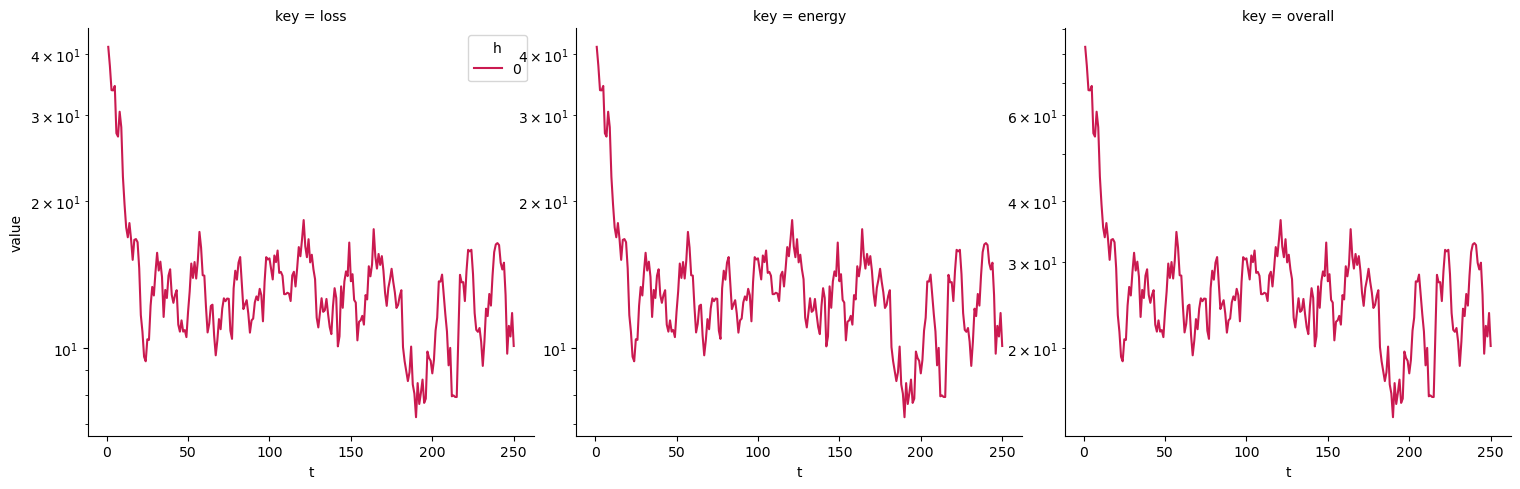

<Figure size 640x480 with 0 Axes>

In [39]:
y = torch.ones(64, output_size) # target data
pseudo_input = torch.zeros(64, 1) # This data is only used to set the batch_size of the PCLayers.
# perform inference
output = inference_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=True, is_return_results_every_t=True) 

### Train the model

Update trainer for learning

In [40]:
training_trainer = pc.PCTrainer(mcpc_model, 
    T = T_mixing + T_sampling, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "last",                       # update when parameters are updated to enable learning    
    accumulate_p_at=[i + T_mixing for i in range(T_sampling)],  # accumulate the gradients of the parameters during all the sampling iterations
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = []                  # remove plotting to improve inference speed
)

Generate training set as samples from a normal distribution

In [41]:
# data parameters
mu=1.               # data mean
var=5.              # data variance
batch_size = 256    
n = 150              # number of batches

# generate data
data = [mu + np.sqrt(var)*torch.randn(batch_size, output_size) for i in range(n)]

In [42]:
n_epochs = 3   # set number of epochs for training

# train pc model
energy=[np.inf]       # stored overall energy after each iteration
for idx_epoch in range(n_epochs):
    for i, y in enumerate(pbar := tqdm(data, desc=f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")):
        pseudo_input = torch.zeros(batch_size, 1) # pseudo input data, This data is only used to set the batch_size of the PCLayers
        output = training_trainer.train_on_batch(inputs=pseudo_input, loss_fn=fe_fn, loss_fn_kwargs={'_target':y}, is_log_progress=False, is_return_results_every_t=False, is_return_outputs=True, is_checking_after_callback_after_t=False)
        energy += output["overall"]
        # Update the tqdm description
        pbar.set_description(f"Epoch: {idx_epoch+1}, Energy: {round(energy[-1],2)}")

    print(mcpc_model[0].bias)
    print(mcpc_model[2].weight)
        

Epoch: 1, Energy: 263.33: 100%|██████████| 150/150 [00:26<00:00,  5.71it/s]


Parameter containing:
tensor([[0.4928]], requires_grad=True)
Parameter containing:
tensor([[2.0598]], requires_grad=True)


Epoch: 2, Energy: 270.63: 100%|██████████| 150/150 [00:25<00:00,  5.87it/s]


Parameter containing:
tensor([[0.4295]], requires_grad=True)
Parameter containing:
tensor([[2.0626]], requires_grad=True)


Epoch: 3, Energy: 237.48: 100%|██████████| 150/150 [00:27<00:00,  5.41it/s]

Parameter containing:
tensor([[0.4337]], requires_grad=True)
Parameter containing:
tensor([[2.2328]], requires_grad=True)


### Assess the leanring performance of the model

MCPC's dynamics can also be used to generate from the learned data distributions

In [43]:
# add input PC layer x_0 to model 
model_generation = nn.Sequential(
    mcpc_model[:],
    pc.PCLayer(sample_x_fn=sample_x_fn, energy_fn=pc_energy_fn, energy_fn_kwargs={"var": 1.}) #sample_x_fn=sample_x_fn, energy_fn=mcpc_energy_fn, energy_fn_kwargs={'lr': optimizer_x_kwargs['lr'], 'noise_var': 1.})
)
model_generation.train()    # this function needs to be called because the model is in .eval() mode otherwise which simply performs a forward pass

# setup trainer for generation with large T to get close to the true generative distribution
generation_trainer = pc.PCTrainer(model_generation, 
    T = 3000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 1.052e+02 | o: 1.052e+02 |:   0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer, you have plot_progress_at enabled, this will slow down training. Set to [] to disable it. 
  warnings.warn(
| e: 8.235e+01 | o: 8.235e+01 |: 100%|██████████| 3000/3000 [00:06<00:00, 435.85it/s]
c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictiv

<Figure size 640x480 with 0 Axes>

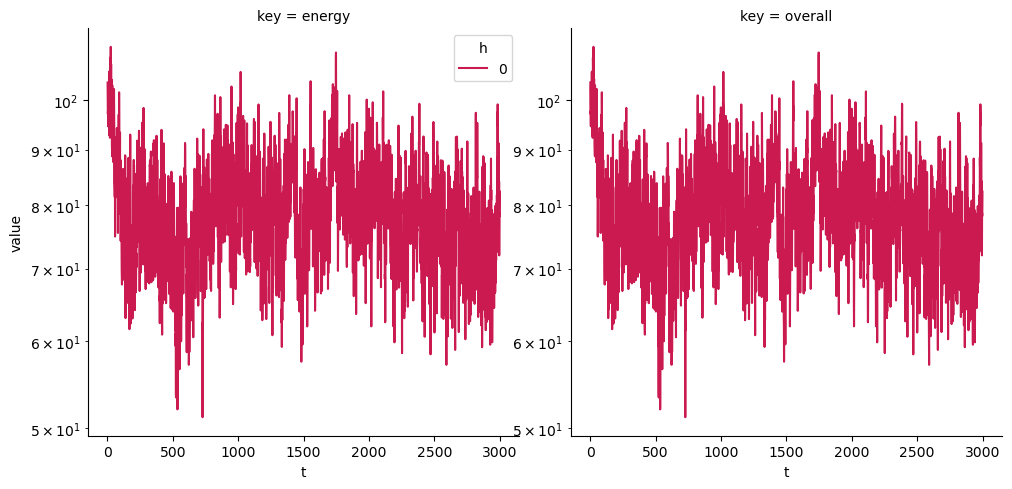

<Figure size 640x480 with 0 Axes>

In [44]:
# run generation with neural network/dynamics
pseudo_input = torch.zeros(100, 1) # This data is only used to set the batch_size of the PCLayers
results = generation_trainer.train_on_batch(inputs=pseudo_input, is_return_results_every_t=True, is_return_outputs = True, is_checking_after_callback_after_t=False)

# extract activity of PC layer x_0 over time
x_0 = [x_0 for x_0 in results["outputs"]]

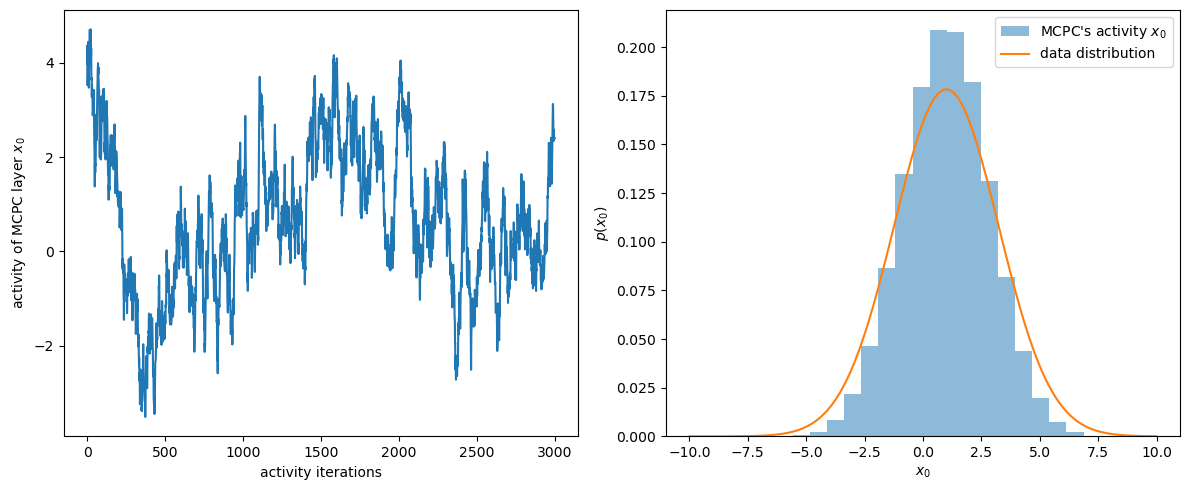

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([x[4,0].item() for x in x_0])
plt.xlabel("activity iterations")
plt.ylabel(r"activity of MCPC layer $x_0$")

# plot histogram of generated data
plt.subplot(1,2,2)
plt.hist(torch.cat(x_0).reshape(-1).detach().numpy(), bins=20, alpha=0.5, label=r"MCPC's activity $x_0$ ", density=True)
# plot data distribution
x = np.linspace(-10,10,100)
plt.plot(x, 1/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x - mu)**2/var), label="data distribution")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$p(x_0)$")
plt.legend()
plt.tight_layout()

In [46]:
print(mcpc_model[0].bias)
print(mcpc_model[2].weight)

Parameter containing:
tensor([[0.4337]], requires_grad=True)
Parameter containing:
tensor([[2.2328]], requires_grad=True)
